In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore, spearmanr, rankdata
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

import feather

### 读取数据
选取2021-04 至 2023-03月数据 频率为4H（个人PC算力限制）

In [2]:
import os

folder_path = 'bitcon/tlkjdata/'  # 替换为实际的文件夹路径

file_list = []  # 存储文件的列表

# 遍历文件夹下的所有文件
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)  # 构建文件的完整路径
    if os.path.isfile(file_path):  # 确保当前路径是文件而不是文件夹
        file_list.append(file_path)  # 将文件路径添加到列表中

In [4]:
def sum_volume(series):
    return series.sum()

universe = pd.DataFrame()
for path in tqdm(file_list):
    df = feather.read_dataframe(path)
    df = df.rename(columns={'vol':'volume'})
    df[['open','close','high','low','volume']] = df[['open','close','high','low','volume']].astype(np.float32)
    half_day_data = df.set_index(['date']).resample('4H').agg({
                    'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':sum_volume})
    start_time = pd.to_datetime('2021-01-01')
    end_time = pd.to_datetime('2023-03-31')
    half_day_data = half_day_data[(half_day_data.index >= start_time) & (half_day_data.index <= end_time)]
    exist_time = (end_time - half_day_data.index[0]).days
    if exist_time <= 260:
        continue
    half_day_data['ts_code'] = path.split('_')[0].split('/')[2]
    universe = universe.append(half_day_data)

100%|███████████████████████████████████████████| 44/44 [01:29<00:00,  2.05s/it]


In [5]:
universe['vwap'] = (universe['low'] + universe['high'] + universe['close'])/3
universe['trade_date'] = universe.index
universe

,open,high,low,close,volume,ts_code,vwap,trade_date
date,,,,,,,,
2021-01-01 00:00:00,124.919998,125.059998,122.889999,124.370003,3.230166e+05,LTCUSDT,124.106667,2021-01-01 00:00:00
2021-01-01 04:00:00,124.370003,125.760002,123.620003,124.360001,1.752255e+05,LTCUSDT,124.579994,2021-01-01 04:00:00
2021-01-01 08:00:00,124.370003,134.229996,123.070000,131.949997,1.181380e+06,LTCUSDT,129.750000,2021-01-01 08:00:00
2021-01-01 12:00:00,131.929993,132.649994,128.110001,129.619995,6.174971e+05,LTCUSDT,130.126663,2021-01-01 12:00:00
2021-01-01 16:00:00,129.630005,130.220001,125.000000,127.870003,7.359510e+05,LTCUSDT,127.696663,2021-01-01 16:00:00
...,...,...,...,...,...,...,...,...
2023-03-30 04:00:00,20.716000,20.728001,20.472000,20.653000,8.061707e+05,ETCUSDT,20.617666,2023-03-30 04:00:00
2023-03-30 08:00:00,20.653000,20.957001,20.000000,20.434000,3.191367e+06,ETCUSDT,20.463667,2023-03-30 08:00:00
2023-03-30 12:00:00,20.433001,20.587999,20.320999,20.506001,1.282417e+06,ETCUSDT,20.471666,2023-03-30 12:00:00


### 构造技术指标为alpha

In [6]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code', 'trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d %H:%M:%S')
        self.df = self.df.set_index(['date']).sort_values(by=['date', 'ts_code'])
        return self.df
    

In [7]:
# add tech indicators
tech_indicator_list = ['log-ret','atr_5', 'close_10_kama_5_30', 'close_10_kama_2_30', 'wt1', 'wt2',
                      'ppo', 'stochrsi', 'cci_6'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)

add tech indicators: 100%|██████████████████████| 36/36 [01:40<00:00,  2.78s/it]


In [8]:
universe['alpha_atr'] = -universe['atr_5']
universe['alpha_wt'] = universe['wt1'] - universe['wt2']
universe['alpha_wtr'] = universe['wt1']
universe['alpha_cci'] = -universe['cci_6']
universe['alpha_srsi'] = -universe['stochrsi']
universe['alpha_ppo'] = universe['ppo']

In [9]:
def alpha_kama(df):
    feature = 'close_10_kama_5_30'
    def cal_(df):
        kama_filter = df[feature].rolling(10).std()
        cond_in1 = (df[feature] - df[feature].shift(1)) >kama_filter
        cond_in2 = (df[feature].shift(1) - df[feature].shift(2)) > kama_filter
        cond_out1 = (df[feature] - df[feature].shift(1)) < -kama_filter
        cond_out2 = (df[feature].shift(1) - df[feature].shift(2)) < -kama_filter
        df['alpha_kama'] = np.where((cond_out1 & cond_out2), -df['close'] , - 0.5*kama_filter)
        df['alpha_kama'] = np.where((cond_in1 & cond_in2), df['close'] , df['alpha_kama'])
        #df['alpha_kama'] = np.where((cond_out1 & cond_out2), df['log-ret']-1, 0)
        #df['alpha_kama'] = np.where((cond_in1 & cond_in2), df['log-ret']+1, df['alpha_kama'])
        
        return df
    
    df_all = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='alpha_kama processing...'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp = cal_(tmp)
        df_all = df_all.append(tmp)
    df_all['alpha_kama2'] = -df_all['close_10_kama_2_30']
    return df_all.sort_values(by=['date', 'ts_code'])

#universe = universe.drop(columns=['alpha_kama'])
universe = alpha_kama(universe)

alpha_kama processing...: 100%|█████████████████| 36/36 [00:01<00:00, 29.38it/s]


In [10]:
from scipy.stats import rankdata
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:, 0], o.iloc[:, 1])[0])
            # s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def delta(df, period=1):
    return df.diff(period)

def ts_rank(data, window=10):
    return data.rolling(window).apply(lambda x: rankdata(x)[-1])

def sma(df, window=10):
    return df.rolling(window).mean()

def ESma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def my_groupby(df, column, func, sort_keys=['date']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_index(level=sort_keys)

In [11]:
def alpha_t1(df):
    def cal_(data):
        data['r_section'] = np.where(data['log-ret']<0, data['log-ret'].rolling(10).std(), data['atr_5']) ** 2
        data['r_section'] = data['r_section'].rolling(5).apply(lambda x: np.argmax(x))
        return data
    
    def smooth_(data):
        data['alpha_t1'] = -data['alpha_t1'].rolling(5).mean()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    df['alpha_t1'] = df.groupby('trade_date')['r_section'].rank(pct=True) - 0.5
    df = my_groupby(df, 'ts_code', smooth_)
    df = df.drop(columns=['r_section'])
    return df

universe = alpha_t1(universe)

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 33.25it/s]


In [12]:
# medcine df not implement
def alpha_t3(df):
    # -1 * sma(ts_rank(rank(self.low), 9)) * sma(rank(close),6)
    def cal1_(data):
        data['alpha_t3'] = data['low'].rolling(9).apply(lambda x: rankdata(x)[-1])
        #data['close_r'] = data['close'].rolling(120).apply(lambda x: x.rank(pct=True)[-1])
        data['alpha_t3'] = -data['alpha_t3'].rolling(6).mean() * data['close_r']
        return data
    
    df['close_r'] = df.groupby('ts_code')['close'].apply(lambda x: x.rolling(6).mean())
    df['close_r'] = df.groupby('trade_date')['close_r'].rank(pct=True)
    df = my_groupby(df, 'ts_code', cal1_)
    df = df.drop(columns=['close_r'])
    return df

universe = alpha_t3(universe)

100%|███████████████████████████████████████████| 36/36 [00:29<00:00,  1.22it/s]


In [13]:
def alpha_t5(df):
    def cal1_(data):
        robj = data['close'].rolling(600)
        data['alpha_t5'] = (data['close'] - robj.mean())/robj.std()
        return data
    
    def cal2_(data):
        p1 = data['low'].rolling(9).apply(lambda x: rankdata(x)[-1])
        data['alpha_t5'] = - p1.rolling(6).mean() * data['alpha_t5']
        return data
        
    df = my_groupby(df, 'ts_code', cal1_)
    df['alpha_t5'] = df.groupby('trade_date')['alpha_t5'].rank(pct=True)
    df = my_groupby(df, 'ts_code', cal2_)
    return df

universe = alpha_t5(universe)    

100%|███████████████████████████████████████████| 36/36 [00:30<00:00,  1.18it/s]


In [14]:
def alpha_t6(df):
    def cal_(data):
        adv20 = sma(data.volume, 10)
        alpha = -1 * ts_rank(abs(delta(data.close, 5)), 20) * np.sign(delta(data.close, 5))
        alpha[adv20 >= data.volume] = -1
        data['alpha_t6'] = alpha
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t6(universe)    

100%|███████████████████████████████████████████| 36/36 [00:29<00:00,  1.23it/s]


In [15]:
def alpha007(df):
    ####((RANK(MAX((VWAP - CLOSE), 3)) + RANK(MIN((VWAP - CLOSE), 3))) * RANK(DELTA(VOLUME, 3)))###
    def cal_(df):
        rolling_obj = (df['vwap'] - df['close']).rolling(3)
        df['section1'] = rolling_obj.max()
        df['section2'] = rolling_obj.min()
        df['section3'] = -df['volume'].diff(3)
        return df

    df_all = df.groupby('ts_code').apply(cal_)
    df_all[['section1', 'section2', 'section3']] = df_all.groupby('trade_date')[
        ['section1', 'section2', 'section3']].rank(method='min', pct=True)
    df_all['alpha_007'] = (df_all['section1'] + df_all['section2']) * df_all['section3']
    df_all = df_all.drop(columns=['section1', 'section2', 'section3'])
    return df_all
    
universe = alpha007(universe)

In [16]:
def alpha009(df):
    ####SMA(((HIGH+LOW)/2-(DELAY(HIGH,1)+DELAY(LOW,1))/2)*(HIGH-LOW)/VOLUME,7,2)###
    def cal_(df):
        term = ((df.high + df.low) / 2 - (df.high.diff(1) + df.low.diff(1)) / 2) \
                * (df.high - df.low) / np.log(df.volume)
        df['alpha_009'] = -ESma(term, 7, 2)
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha009(universe)    

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 30.02it/s]


In [17]:
def alpha010(df):
    ####(RANK(MAX(((RET < 0) ? STD(RET, 20) : CLOSE)^2),5))###
    def cal_(df):
        df['alpha_010'] = np.where(df['log-ret'] < 0, df['log-ret'].rolling(20).std(), df['close'])
        df['alpha_010'] = -(df['alpha_010'] ** 2).rolling(window=6).max()
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha010(universe)    

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 28.37it/s]


In [18]:
def alpha021(df):
    ####REGBETA(MEAN(CLOSE,6),SEQUENCE(6))###
    def cal_(df):
        df['alpha_021'] = Regbeta(df['close'].rolling(6).mean(), np.arange(1, 6+1))
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha021(universe)    

100%|███████████████████████████████████████████| 36/36 [00:37<00:00,  1.05s/it]


In [19]:
def alpha023(df):
    ####SMA((CLOSE>DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1) / (SMA((CLOSE>DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1) + SMA((CLOSE<=DELAY(CLOSE,1)?STD(CLOSE,20):0),20,1))*100###
    def cal_(df):
        cond = df['close'] > df['close'].shift(1)
        part1 = df.close.copy(deep=True)
        part1[cond] = df['close'].rolling(window=6).std()
        part1[~cond] = 0
        part2 = df.close.copy(deep=True)
        part2[~cond] = df['close'].rolling(window=6).std()
        part2[cond] = 0
        df['alpha_023'] = 100 * ESma(part1, 6, 1) / (ESma(part1, 6, 1) + ESma(part2, 6, 1))
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha023(universe) 

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 22.50it/s]


In [20]:
def alpha026(df):
    ####((((SUM(CLOSE, 7) / 7) - CLOSE)) + ((CORR(VWAP, DELAY(CLOSE, 5), 230))))###
    def cal_(df):
        df['section1'] = (df['close'].rolling(6).mean() - df['close'])
        df['section2'] = df['close'].shift(5)
        df['section2'] = Corr(df[['vwap', 'section2']], 20)
        df['alpha_026'] = df['section1'] + df['section2']
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha026(universe) 

100%|███████████████████████████████████████████| 36/36 [02:33<00:00,  4.28s/it]


In [21]:
def alpha040(df):
    ####SUM((CLOSE>DELAY(CLOSE,1)?VOLUME:0),26)/SUM((CLOSE<=DELAY(CLOSE,1)?VOLUME:0),26)*100###
    def cal_(df):
        cond = df['close'] > df['close'].shift(1)
        df['section1'] = np.where(cond, df['volume'], 0)
        df['section2'] = np.where(~cond, df['volume'], 0)
        df['section1'] = df['section1'].rolling(10).sum()
        df['section2'] = df['section2'].rolling(10).sum()
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df['alpha_040'] = -df['section1'] / (df['section2'])
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha040(universe) 

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 26.15it/s]


In [22]:
def alpha122(df):
    ####(SMA(SMA(SMA(LOG(CLOSE),13,2),13,2),13,2)-DELAY(SMA(SMA(SMA(LOG(CLOSE),13,2),13,2),13,2),1))/DELAY(SMA(SMA(SMA(LOG(CLOSE),13,2),13,2),13,2),1)###
    def cal_(df):
        df['alpha_122'] = (ESma(ESma(ESma(np.log(df['close']), 13, 2), 13, 2), 13, 2) - (
            ESma(ESma(ESma(np.log(df['close']), 13, 2), 13, 2), 13, 2)).shift(1)) / \
                          (ESma(ESma(ESma(np.log(df['close']), 13, 2), 13, 2), 13, 2)).shift(1)
        df['alpha_122'] = -df['alpha_122']
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha122(universe) 

100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 25.55it/s]


In [23]:
bak = universe.copy(deep=True)
universe.ts_code.unique()[10:20]

array(['BCHUSDT', 'TOMOUSDT', 'XLMUSDT', 'DOGEUSDT', 'XRPUSDT',
       'ALGOUSDT', 'ATOMUSDT', 'RENUSDT', 'FTMUSDT', 'SXPUSDT'],
      dtype=object)

<AxesSubplot:xlabel='date'>

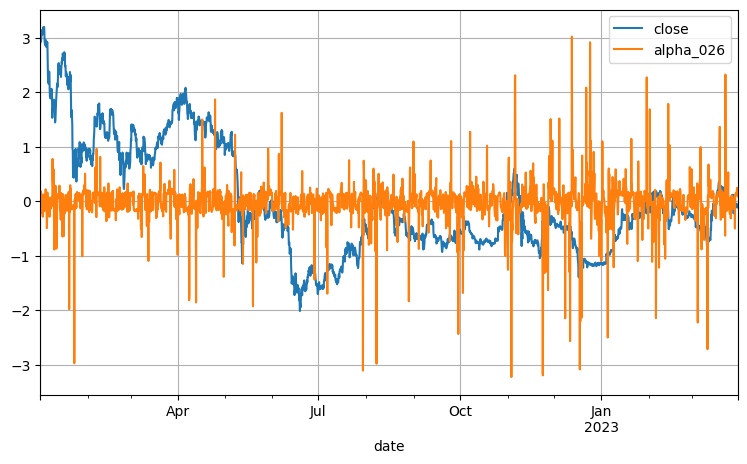

In [102]:
tmp = universe.loc[universe.ts_code=='BNBUSDT']
#tmp['alpha_t6'] = tmp['alpha_t6']/10
#tmp['alpha_t5'] = tmp['alpha_t5']* 5
#tmp['alpha_atr'] = tmp['alpha_atr']* 20
tmp = tmp.loc[tmp['trade_date']>'20220101']
tmp[['close']] = tmp[['close']].apply(zscore)
tmp[['close', 'alpha_026']].plot(grid=True)

In [26]:
universe.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ts_code', 'vwap',
       'trade_date', 'log-ret', 'atr_5', 'close_10_kama_5_30',
       'close_10_kama_2_30', 'wt1', 'wt2', 'ppo', 'stochrsi', 'cci_6',
       'alpha_atr', 'alpha_wt', 'alpha_wtr', 'alpha_cci', 'alpha_srsi',
       'alpha_ppo', 'alpha_kama', 'alpha_kama2', 'alpha_t1', 'alpha_t3',
       'alpha_t5', 'alpha_t6', 'alpha_007', 'alpha_009', 'alpha_010',
       'alpha_021', 'alpha_023', 'alpha_026', 'alpha_040', 'alpha_122'],
      dtype='object')

In [27]:
universe.to_csv('factor_data/qurterday_bitcon.csv')

In [28]:
universe

,open,high,low,close,volume,ts_code,vwap,trade_date,log-ret,atr_5,...,alpha_t5,alpha_t6,alpha_007,alpha_009,alpha_010,alpha_021,alpha_023,alpha_026,alpha_040,alpha_122
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.178070,0.182810,0.177470,0.181690,8.284419e+07,ADAUSDT,0.180657,2021-01-01 00:00:00,0.000000,0.005340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00,736.260010,743.729980,725.619995,739.530029,4.215141e+05,ETHUSDT,736.293274,2021-01-01 00:00:00,0.000000,18.109985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00,5.596000,5.664000,5.572000,5.640000,2.706588e+05,ETCUSDT,5.625333,2021-01-01 00:00:00,0.000000,0.092000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00,1.453300,1.544500,1.446500,1.541000,2.229141e+06,SOLUSDT,1.510667,2021-01-01 00:00:00,0.000000,0.098000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:00:00,2.414900,2.534400,2.408800,2.507500,8.201741e+05,OMGUSDT,2.483567,2021-01-01 00:00:00,0.000000,0.125600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 20:00:00,123.089996,123.129997,121.779999,121.970001,8.388282e+04,BCHUSDT,122.293335,2023-03-30 20:00:00,-0.009059,2.019329,...,-1.803030,-1.0,0.047521,-2.082545e+01,-1.519056e+04,0.044667,30.520490,-0.988220,-0.656566,0.000058
2023-03-30 20:00:00,1.601000,1.605000,1.586000,1.592000,4.181286e+06,OMGUSDT,1.594333,2023-03-30 20:00:00,-0.006262,0.055916,...,-0.848485,-1.0,0.778926,-5.259581e-03,-2.968729e+00,-0.020186,13.513330,-0.365316,-0.065015,0.006444
2023-03-30 20:00:00,0.041440,0.041490,0.040890,0.041150,1.606737e+08,GALAUSDT,0.041177,2023-03-30 20:00:00,-0.006781,0.001072,...,-4.000000,-1.0,1.171488,-2.075561e-06,-1.755610e-03,0.000205,59.530993,-0.317643,-1.360159,0.000726


### 因子评估

In [82]:
factor_names = [
       'alpha_atr', 'alpha_wt', 'alpha_wtr', 'alpha_cci', 'alpha_srsi',
       'alpha_ppo', 'alpha_kama', 'alpha_kama2', 'alpha_t1', 'alpha_t3',
       'alpha_t5', 'alpha_t6', 'alpha_007', 'alpha_009', 'alpha_010',
       'alpha_021', 'alpha_023', 'alpha_026', 'alpha_040', 'alpha_122'
        ]

In [83]:
def rescale_(data, zscore_features=factor_names):
    data[factor_names] = data[factor_names].apply(zscore)
    # resize from -1 to 1
    for feature in zscore_features:
        max_val = data[feature].median() + 3.3*data[feature].std()
        min_val = data[feature].median() - 3.3*data[feature].std()
        data[feature] = np.where(data[feature]>max_val, max_val, 
                               np.where(data[feature]<min_val, min_val, data[feature]))
        #data[feature] = (data[feature] - data[feature].mean())/data[feature].std()
        #data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                                 #np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

def zscore_by_sector(df, zscore_features):
    
    df_all = pd.DataFrame()
    for val in tqdm(df.industry.unique()):
        tmp = df.loc[df.industry == val]
        tmp[zscore_features] = tmp.groupby('trade_date')[zscore_features].apply(rescale_, zscore_features)
        df_all = df_all.append(tmp)

    return df_all.sort_index(level=['date'])

def zscore_by_close_level(df, zscore_features):
    df_all = pd.DataFrame()
    for val in tqdm(df.close_level.unique()):
        tmp = df.loc[df.close_level == val]
        tmp[zscore_features] = tmp.groupby('trade_date')[zscore_features].apply(rescale_, zscore_features)
        df_all = df_all.append(tmp)

    return df_all.sort_index(level=['date'])

universe = universe.replace([np.inf, -np.inf], np.nan)
universe = universe.fillna(0.)

#universe = zscore_by_sector(universe, factor_names)
#universe_2 = zscore_by_close_level(universe_2, factor_names)
universe[factor_names] = universe.groupby('trade_date')[factor_names].apply(rescale_)

<AxesSubplot:>

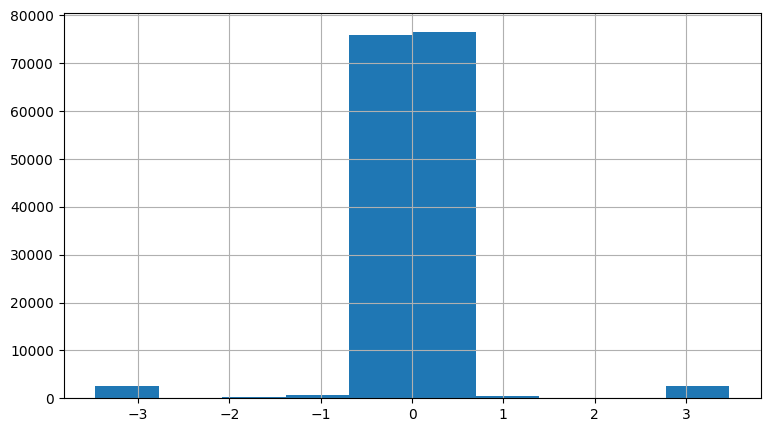

In [99]:
universe['alpha_026'].hist()

In [91]:
# universe['alpha_srsi'] = -universe['alpha_srsi']
# universe['alpha_wt'] = -universe['alpha_wt']

In [92]:
universe = universe.sort_values(by=['date','ts_code'])
universe_est = universe.copy(deep=True)
universe_est.index.unique()

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 04:00:00',
               '2021-01-01 08:00:00', '2021-01-01 12:00:00',
               '2021-01-01 16:00:00', '2021-01-01 20:00:00',
               '2021-01-02 00:00:00', '2021-01-02 04:00:00',
               '2021-01-02 08:00:00', '2021-01-02 12:00:00',
               ...
               '2023-03-29 12:00:00', '2023-03-29 16:00:00',
               '2023-03-29 20:00:00', '2023-03-30 00:00:00',
               '2023-03-30 04:00:00', '2023-03-30 08:00:00',
               '2023-03-30 12:00:00', '2023-03-30 16:00:00',
               '2023-03-30 20:00:00', '2023-03-31 00:00:00'],
              dtype='datetime64[ns]', name='date', length=4915, freq=None)

In [93]:
dates = pd.date_range(end=pd.to_datetime('20230331', format='%Y%m%d'), 
                      periods=len(universe_est.index.unique()), freq='D')
dates

DatetimeIndex(['2009-10-16', '2009-10-17', '2009-10-18', '2009-10-19',
               '2009-10-20', '2009-10-21', '2009-10-22', '2009-10-23',
               '2009-10-24', '2009-10-25',
               ...
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25',
               '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31'],
              dtype='datetime64[ns]', length=4915, freq='D')

In [94]:
df = pd.DataFrame()
for ts_code in universe_est.ts_code.unique():
    tmp = universe_est.loc[universe_est.ts_code==ts_code]
    tmp['fake_date'] = dates[(len(universe_est.index.unique()) - tmp.shape[0]):]
    df = df.append(tmp)
df = df.sort_values(by=['date','ts_code'])

In [95]:
all_factors = df.copy(deep=True)\
            [factor_names + ['fake_date','ts_code','close', 'log-ret']]
all_factors.reset_index(drop=True, inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['fake_date'], format='%Y-%m-%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date', 'ts_code'])
print(all_factors.shape)

(159567, 23)


In [96]:
import alphalens as al
from scipy.stats import zscore
import helper.project_helper as ph

shift_day = -1
tmp = df.copy(deep=True)
tmp['close'] = tmp.groupby('ts_code')['close'].shift(shift_day)
all_pricing = tmp.reset_index().pivot(index='fake_date', columns='ts_code', values='close')
#all_pricing = all_pricing.loc[all_pricing.index[::5]]

def show_sample_results(factors_with_alpha, features, pricing=all_pricing, holding_time=1):
    factors_with_alpha = factors_with_alpha[features]
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha, pricing, holding_time=holding_time)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)
    
    qr_factor_returns = pd.DataFrame()
    for factor, factor_data in factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(8,2),
        figsize=(12, 8),
        legend=False)

#all_pricing.head()

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

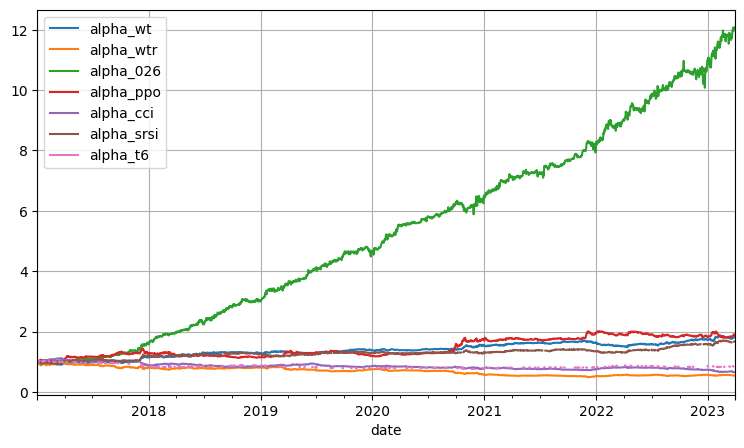

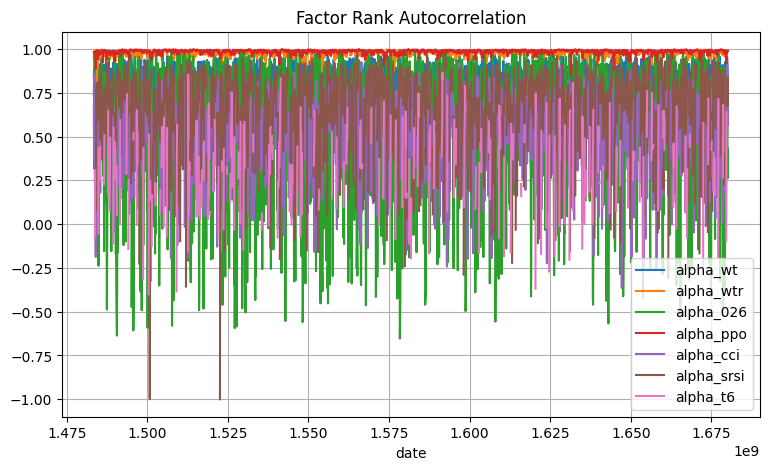

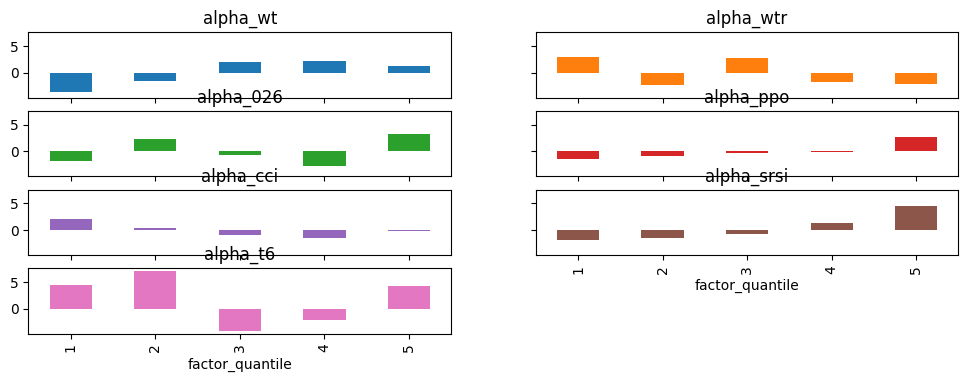

In [97]:
features = [
       'alpha_wt', 'alpha_wtr',  
       #'alpha_kama', 'alpha_kama2', 'alpha_t1', 'alpha_t3','alpha_atr', 
       #'alpha_t5',  'alpha_007', 'alpha_009', 'alpha_010',
       'alpha_026', 'alpha_ppo', 'alpha_cci','alpha_srsi', 'alpha_t6',
        ]
cond1 = all_factors['fake_date']>'20170101'
cond2 = all_factors['fake_date']<'20230513'
eva_df = all_factors.loc[cond1 & cond2]
show_sample_results(eva_df, features, pricing=all_pricing, holding_time=1)

In [98]:
universe.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ts_code', 'vwap',
       'trade_date', 'log-ret', 'atr_5', 'close_10_kama_5_30',
       'close_10_kama_2_30', 'wt1', 'wt2', 'ppo', 'stochrsi', 'cci_6',
       'alpha_atr', 'alpha_wt', 'alpha_wtr', 'alpha_cci', 'alpha_srsi',
       'alpha_ppo', 'alpha_kama', 'alpha_kama2', 'alpha_t1', 'alpha_t3',
       'alpha_t5', 'alpha_t6', 'alpha_007', 'alpha_009', 'alpha_010',
       'alpha_021', 'alpha_023', 'alpha_026', 'alpha_040', 'alpha_122'],
      dtype='object')

In [105]:
features = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume',  'vwap','trade_date', 
            'alpha_wt', 'alpha_wtr', 'alpha_026', 'alpha_ppo', 'alpha_cci', 'alpha_srsi', 'alpha_t6']

save_date = universe.loc[universe['trade_date']>='2022-04-01']
save_date[features].reset_index().to_feather('factor_data/bitcon_zscore.feather')

In [106]:
df = feather.read_dataframe('factor_data/bitcon_zscore.feather')
df

,date,ts_code,log-ret,open,high,low,close,volume,vwap,trade_date,alpha_wt,alpha_wtr,alpha_026,alpha_ppo,alpha_cci,alpha_srsi,alpha_t6
0,2022-04-01 00:00:00,1000SHIBUSDT,-0.031025,0.026613,0.026660,0.025486,0.025800,6.947246e+09,0.025982,2022-04-01 00:00:00,-0.920050,0.324325,-0.190533,-0.235016,0.620041,-0.435710,0.923562
1,2022-04-01 00:00:00,ADAUSDT,-0.021300,1.172100,1.172800,1.134000,1.147300,1.570899e+08,1.151367,2022-04-01 00:00:00,-0.529469,0.602066,-0.190372,-0.354961,0.799703,-0.435710,1.019480
2,2022-04-01 00:00:00,ALGOUSDT,-0.028850,0.942200,0.945700,0.908600,0.915600,3.287401e+07,0.923300,2022-04-01 00:00:00,0.760001,0.045365,-0.189082,-0.306981,-0.099469,-0.435710,-0.227465
3,2022-04-01 00:00:00,APEUSDT,-0.031089,13.101000,13.160000,12.641000,12.699000,7.544404e+06,12.833333,2022-04-01 00:00:00,-0.817422,2.287048,-0.183904,-0.778899,0.286094,-0.435710,-0.898897
4,2022-04-01 00:00:00,ATOMUSDT,-0.032118,29.676001,29.738001,28.368999,28.738001,3.645994e+06,28.948334,2022-04-01 00:00:00,-0.685978,0.793683,-0.182477,-0.484590,1.173646,-0.435710,1.019480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78234,2023-03-30 20:00:00,SANDUSDT,-0.009492,0.624400,0.624700,0.614100,0.618600,1.583321e+07,0.619133,2023-03-30 20:00:00,-1.031357,0.662863,-0.237058,-0.570654,0.588583,-0.655816,0.154992
78235,2023-03-30 20:00:00,TOMOUSDT,-0.009337,0.667000,0.668700,0.658100,0.660900,7.609279e+06,0.662567,2023-03-30 20:00:00,-0.054496,-0.955022,-0.221190,2.348301,-0.061397,-0.657655,0.154992
78236,2023-03-30 20:00:00,XLMUSDT,-0.007116,0.105750,0.106360,0.104480,0.105020,1.104864e+08,0.105287,2023-03-30 20:00:00,0.707084,-1.951146,-0.219328,1.640315,-1.626230,-0.198767,0.154992
78237,2023-03-31 00:00:00,BTCUSDT,-0.011075,28282.800781,28285.099609,27654.099609,27971.300781,1.769188e+05,27970.166016,2023-03-31 00:00:00,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000


In [80]:
eva_df.index.get_level_values(0).unique()

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
               '2017-01-10', '2017-01-11',
               ...
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25',
               '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31'],
              dtype='datetime64[ns]', name='date', length=2280, freq=None)

In [ ]:
## shif return 5 days
all_factors = universe.copy(deep=True)
#all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-1)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['trade_date', 'ts_code'])
print(universe.shape, all_factors.shape)

In [ ]:
from statsmodels.formula.api import ols

def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.5, 0.5)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors.index=='2023-03-30 18:00:00'])

In [ ]:
base_field = ['ts_code','trade_date', 'close', 'log-ret']
date_and_code = [ 'trade_date','ts_code', 'returns_2']
alpha_field = [
       'alpha_atr', 'alpha_atr14', 'alpha_wt', 'alpha_wtr', 'alpha_kama', 'alpha_kama2', 
       'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_t5', 'alpha_t6', 
       'alpha_007', 'alpha_009', 'alpha_010', 'alpha_021', 'alpha_023', 'alpha_026', 'alpha_040', 'alpha_122'
        ]

start_time = '2022-04-01 00:00:00'
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df['trade_date']>=start_time]
calendar = alpha_df.trade_date.unique() # int64

#only for positive estimate
# for feature in alpha_field:
#     alpha_df[feature] = np.where(alpha_df[feature]>=0.7, alpha_df[feature], np.where(alpha_df[feature]<=-0.7, alpha_df[feature], 0))
#     alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-5]]

In [ ]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)
alpha_field = [
       #'alpha_atr', 'alpha_atr14', 'alpha_wt', 'alpha_wtr', 'alpha_kama', 'alpha_kama2', 
       #'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_t5', 'alpha_t6', 
       #'alpha_007', 'alpha_009', 'alpha_010', 'alpha_021', 'alpha_023', 'alpha_026', 'alpha_040', 
        'alpha_122'
        ]

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()